# Goal

* Trying varying levels of bandwidth and DBL scaling with pre-fractionation abundances ('DBL-comm')
* Varying parameters
  * bandwidth (bw)
    * 0.006, 0.02, 0.2, 0.4, 0.6, 0.8
  * diffusive boundary layer (DBL) scaling (DBL scaling by abundance)
    * 0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8
* **NOTE:** using default bandwidth for DBL & isotope incorporation steps
* **NOTE:** using less replicate Monte Carlo replicates to save on memory
* **NOTE:** notebook previously callded "rep4_DBL-comm_bw_ALL4"

## Init

In [14]:
import os
import glob
import re
import nestly

In [15]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [16]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

### BD min/max

In [17]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Nestly

* assuming fragments already simulated

In [18]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'rep4_DBL-comm_bw_ALL4')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde.pkl'
commFile = '/home/nick/notebook/SIPSim/dev/fullCyc/fullCyc_12C-Con_trm_comm.txt'

# emperical data for validation
emp_shan_file = '/home/nick/notebook/SIPSim/dev/fullCyc_trim/SIP-core_unk_shan.txt'
emp_BDspan_file = '/home/nick/notebook/SIPSim/dev/fullCyc_trim/SIP-core_unk_trm_BD-span.txt'
emp_corr_file = '/home/nick/notebook/SIPSim/dev/fullCyc_trim/SIP-core_unk_trm_corr.txt'

nreps = 4

In [19]:
# building tree structure
nest = nestly.Nest()

# varying params
nest.add('DBL_scaling', [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
nest.add('bandwidth', [0.002, 0.02, 0.2, 0.4, 0.6, 0.8])
nest.add('rep', [x + 1 for x in xrange(nreps)])

## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [8], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('min_BD', [min_BD], create_dir=False)
nest.add('max_BD', [max_BD], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('commFile', [commFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [20]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'

echo '# shuffling taxa in comm file'
comm_shuffle_taxa.r {commFile} > comm.txt

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    --BD_min {min_BD} \
    --BD_max {max_BD} \
    comm.txt \
    > fracs.txt 
    
echo '# adding diffusion'    
SIPSim diffusion \
    {fragFile} \
    -n 100000 \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    -n 100000 \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    -n 100000 \
    --comm comm.txt \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#-- w/ PCR simulation --#
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    

#-- w/out PCR simulation --#    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt    
    
    
    
#-- making summary tables --#
# PCR
shannon_calc.r OTU_abs{abs}_PCR_sub.txt > OTU_abs{abs}_PCR_sub_shan.txt
BD_span_calc.r OTU_abs{abs}_PCR_sub.txt comm.txt > OTU_abs{abs}_PCR_sub_BD-span.txt
correlogram_make.r OTU_abs{abs}_PCR_sub.txt > OTU_abs{abs}_PCR_sub_corr.txt    
# no PCR
shannon_calc.r OTU_abs{abs}_sub.txt > OTU_abs{abs}_sub_shan.txt
BD_span_calc.r OTU_abs{abs}_sub.txt comm.txt > OTU_abs{abs}_sub_BD-span.txt
correlogram_make.r OTU_abs{abs}_sub.txt > OTU_abs{abs}_sub_corr.txt


#-- removing large intermediate files --#
rm -f ampFrags_KDE_dif.pkl
rm -f ampFrags_KDE_dif_DBL.pkl
rm -f ampFrags_KDE_dif_DBL_inc.pkl

Writing /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep4_DBL-comm_bw_ALL4/SIPSimRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun --template-file $bashFile -d rep4_DBL-comm_bw_ALL4 --log-file log.txt -j 2

2016-06-17 09:16:10,475 * INFO * Template: ./SIPSimRun.sh
2016-06-17 09:16:10,476 * INFO * [181775] Started ./SIPSimRun.sh in rep4_DBL-comm_bw_ALL4/0.4/0.4/3
2016-06-17 09:16:10,478 * INFO * [181776] Started ./SIPSimRun.sh in rep4_DBL-comm_bw_ALL4/0.4/0.4/2
2016-06-17 09:29:01,034 * INFO * [181776] rep4_DBL-comm_bw_ALL4/0.4/0.4/2 Finished with 0
2016-06-17 09:29:01,048 * INFO * [183750] Started ./SIPSimRun.sh in rep4_DBL-comm_bw_ALL4/0.4/0.4/1
2016-06-17 09:29:01,594 * INFO * [181775] rep4_DBL-comm_bw_ALL4/0.4/0.4/3 Finished with 0
2016-06-17 09:29:01,607 * INFO * [183762] Started ./SIPSimRun.sh in rep4_DBL-comm_bw_ALL4/0.4/0.4/4
2016-06-17 09:41:27,309 * INFO * [183750] rep4_DBL-comm_bw_ALL4/0.4/0.4/1 Finished with 0
2016-06-17 09:41:27,326 * INFO * [186084] Started ./SIPSimRun.sh in rep4_DBL-comm_bw_ALL4/0.4/0.002/3
2016-06-17 09:41:34,835 * INFO * [183762] rep4_DBL-comm_bw_ALL4/0.4/0.4/4 Finished with 0
2016-06-17 09:41:34,849 * INFO * [186160] Started ./SIPSimRun.sh in rep4_DBL-com

In [ ]:
%pushnote rep4_DBL-comm_bw_ALL4 complete

# Comparing to emperical data

* correlation/regression analyses of metrics on community composition

In [23]:
%%R

# function for loading dataset files
load.data.files = function(sim.files, emp.file){
    # loading
    ## simulations
    df = list()
    for(x in sim.files){
        # simulation
        tmp = read.delim(x, sep='\t')
        xx = strsplit(x, '/')[[1]]
        tmp$DBL_scale = xx[10] %>% as.numeric
        tmp$bw = xx[11] %>% as.numeric
        tmp$SIM_rep = xx[12] %>% as.numeric  
        tmp$dataset = 'Simulation'       
        df[[x]] = tmp 
        
        # emperical (matched for each simulation)
        if(xx[12] %>% as.numeric == 1){
            tmp = read.delim(emp.file, sep='\t')
            tmp$DBL_scale = xx[10] %>% as.numeric
            tmp$bw = xx[11] %>% as.numeric
            tmp$SIM_rep = 1
            tmp$dataset = 'Emperical'        
            xy = paste0(x, '_EMP')
            df[[xy]] = tmp
        }
    }
    df = do.call(rbind, df) %>% as.data.frame 
    rownames(df) = 1:nrow(df)

    # return
    return(df)
    }

## Shannon index

In [24]:
sim_shan_files = !find $buildDir -name "OTU_abs1e9_PCR_sub_shan.txt"
print len(sim_shan_files)

192


In [25]:
# checking for empty files
for x in sim_shan_files:
    ret = !ls -thlc $x
    if ret[0].split(' ')[4] == '0':
        print ret

In [26]:
%%R -i sim_shan_files -i emp_shan_file

df.shan = load.data.files(sim_shan_files, emp_shan_file) 
df.shan %>% tail(n=3)

      library      sample                            OTU Buoyant_density
11712       1 1.757-1.764 Acaryochloris_marina_MBIC11017           1.760
11713       1 1.764-1.768 Acaryochloris_marina_MBIC11017           1.766
11714       1 1.768-1.774 Acaryochloris_marina_MBIC11017           1.771
       shannon DBL_scale   bw SIM_rep    dataset
11712 4.976957       0.8 0.02       4 Simulation
11713 4.919435       0.8 0.02       4 Simulation
11714 4.919722       0.8 0.02       4 Simulation


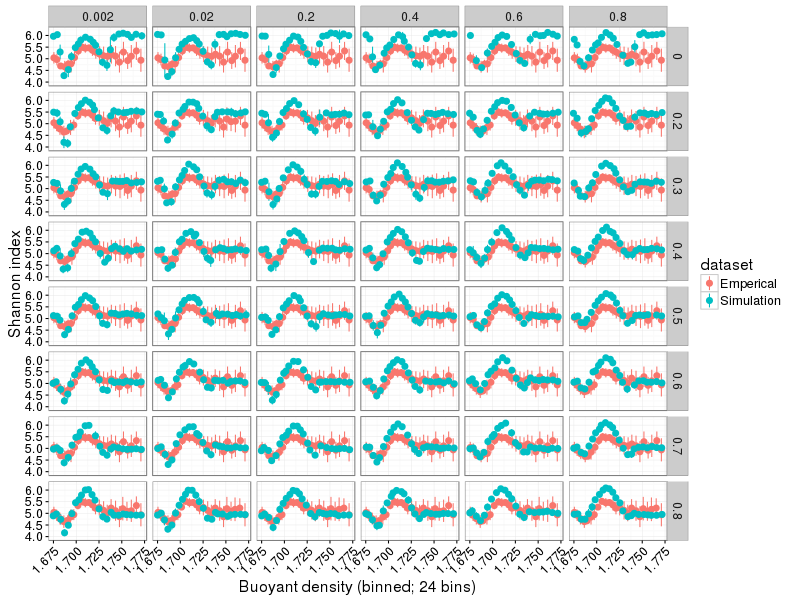

In [27]:
%%R -w 800 -h 600
# summarizing
df.shan.s = df.shan %>%
    group_by(dataset, bw, DBL_scale, BD_bin = ntile(Buoyant_density, 24)) %>%
    summarize(mean_shannon = mean(shannon), 
              sd_shannon = sd(shannon), 
              mean_BD = mean(Buoyant_density))

ggplot(df.shan.s, aes(mean_BD, mean_shannon, color=dataset,
                      ymin=mean_shannon-sd_shannon, ymax=mean_shannon+sd_shannon)) +
    geom_pointrange() +
    facet_grid(DBL_scale ~ bw) +
    labs(x='Buoyant density (binned; 24 bins)', y='Shannon index') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

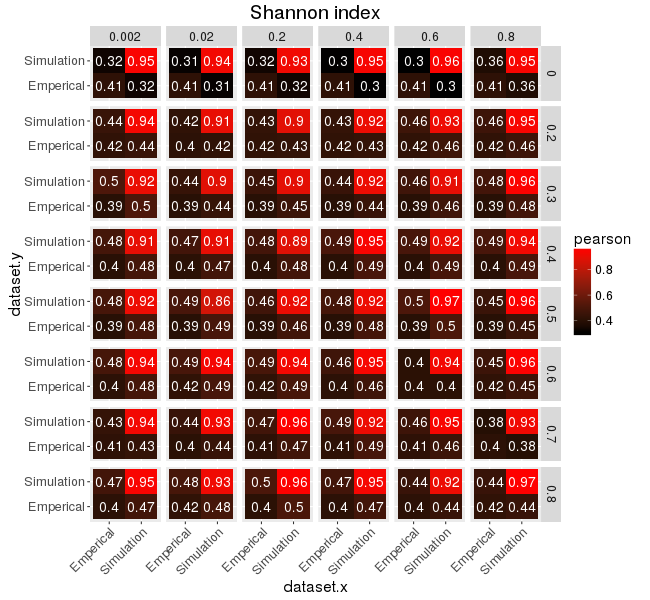

In [28]:
%%R -w 650 -h 600
# pairwise correlations for each dataset
df.shan.bin = df.shan %>%
    group_by(BD_bin = ntile(Buoyant_density, 24))

calc.pearson = function(x){
    cor(x[,'shannon.x'], x['shannon.y'], method='pearson')[1,1]
}


df.shan.corr = inner_join(df.shan.bin, df.shan.bin, c('BD_bin' = 'BD_bin',
                                                      'bw' = 'bw',
                                                      'DBL_scale' = 'DBL_scale')) %>%
    group_by(bw, DBL_scale, dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))

        
# plotting
ggplot(df.shan.corr, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(title='Shannon index') +
    facet_grid(DBL_scale ~ bw) +        
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)        
    )  

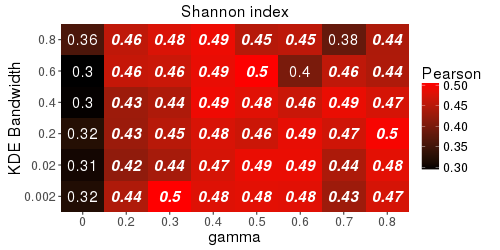

In [74]:
%%R -w 500 -h 250

# getting emperical-emperical corr        
emp.val = df.shan.corr %>% 
    filter((dataset.x == 'Emperical' &
            dataset.y == 'Emperical')) %>%
    group_by() %>%
    summarize(max_value = max(pearson)) %>%
    ungroup() %>%
    select(max_value) %>% as.matrix %>% as.vector
emp.val = emp.val[1] 

# filtering 
df.shan.corr.f = df.shan.corr %>% 
    filter((dataset.x == 'Simulation' &
            dataset.y == 'Emperical')) %>%
    mutate(DBL_scale = DBL_scale %>% as.character,
           bw = bw %>% as.character,
           gt_emp = ifelse(round(pearson,2) >= round(emp.val, 2), 'bold.italic', 'plain')) %>%
    complete(DBL_scale, bw)
df.shan.corr.f %>% head(n=3)
   
        
# plotting
p.shan = ggplot(df.shan.corr.f, aes(DBL_scale,bw, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt,fontface=gt_emp), color='white', size=5.5) +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_discrete(expand=c(0,0)) +
    scale_color_manual(values=c('white', 'black')) +
    scale_fill_gradient('Pearson', low='black', high='red') +
    labs(x='gamma', y='KDE Bandwidth', title='Shannon index') +       
    theme(
        text = element_text(size=16),
        plot.title = element_text(size=16)
    ) 
p.shan

## BD spans

In [30]:
sim_BDspan_files = !find $buildDir -name "OTU_abs1e9_PCR_sub_BD-span.txt"
print len(sim_BDspan_files)
print emp_BDspan_file

192
/home/nick/notebook/SIPSim/dev/fullCyc_trim/SIP-core_unk_trm_BD-span.txt


In [31]:
%%R -i sim_BDspan_files -i emp_BDspan_file
df.BDspan = load.data.files(sim_BDspan_files, emp_BDspan_file) 
df.BDspan %>% head

                                   OTU library mean_preFrac_abund min_BD max_BD
1       Acaryochloris_marina_MBIC11017       1       0.0007433140  1.672  1.775
2       Acetobacterium_woodii_DSM_1030       1       0.0003366196  1.672  1.768
3 Acetobacter_pasteurianus_IFO_3283-03       1       0.0001620700  1.672  1.775
4    Acetohalobium_arabaticum_DSM_5501       1       0.0002365695  1.672  1.772
5         Acholeplasma_laidlawii_PG-8A       1       0.0003956025  1.672  1.775
6             Acholeplasma_palmae_J233       1       0.0001620700  1.672  1.775
  BD_range BD_range_perc DBL_scale  bw SIM_rep    dataset
1    0.103     100.00000       0.4 0.4       3 Simulation
2    0.096      93.20388       0.4 0.4       3 Simulation
3    0.103     100.00000       0.4 0.4       3 Simulation
4    0.100      97.08738       0.4 0.4       3 Simulation
5    0.103     100.00000       0.4 0.4       3 Simulation
6    0.103     100.00000       0.4 0.4       3 Simulation


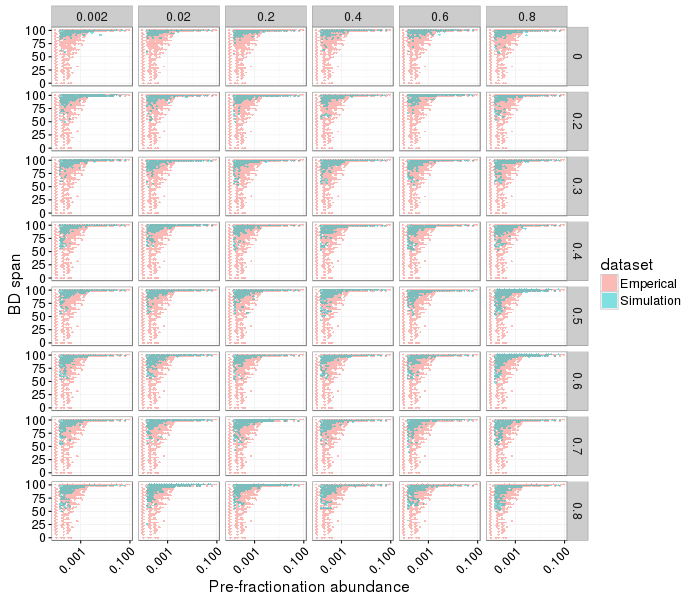

In [32]:
%%R -w 700 -h 600

# plotting
ggplot(df.BDspan, aes(mean_preFrac_abund, BD_range_perc, fill=dataset)) +
    geom_hex(alpha=0.5) +
    scale_x_log10() +
    facet_grid(DBL_scale ~ bw) +
    labs(x='Pre-fractionation abundance', y='BD span') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)        
    )

In [33]:
%%R -i sim_BDspan_files -i emp_BDspan_file

# binning by pre-fractionation abundances
n.tile = 20
df.BDspan = df.BDspan %>%
    group_by(dataset, library, DBL_scale, bw, preFrac_abund_bin = ntile(mean_preFrac_abund, n.tile)) %>%
    summarize(mean_preFrac_abund = mean(mean_preFrac_abund),
              var_BD_range = var(BD_range),
              sd_BD_range = sd(BD_range))

df.BDspan %>% tail(n=3)

Source: local data frame [3 x 8]
Groups: dataset, library, DBL_scale, bw [1]

     dataset library DBL_scale    bw preFrac_abund_bin mean_preFrac_abund
       (chr)   (int)     (dbl) (dbl)             (int)              (dbl)
1 Simulation       1       0.8   0.8                18        0.001632895
2 Simulation       1       0.8   0.8                19        0.002463796
3 Simulation       1       0.8   0.8                20        0.009699813
Variables not shown: var_BD_range (dbl), sd_BD_range (dbl)


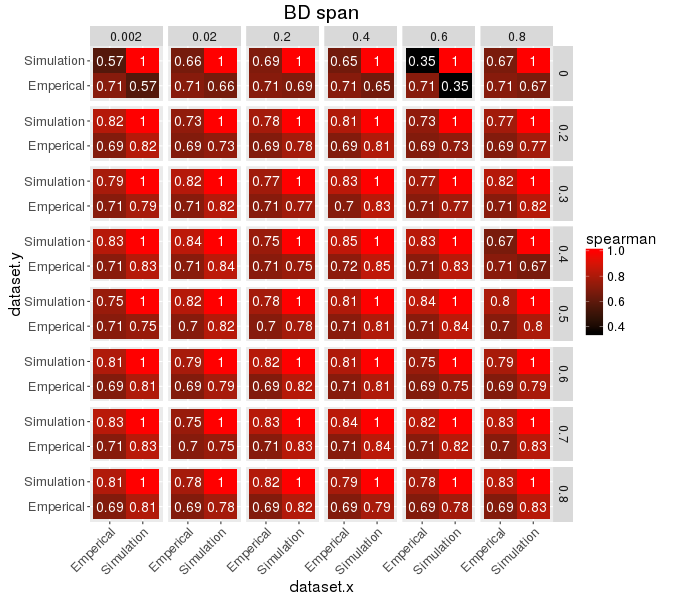

In [34]:
%%R -w 675 -h 600
calc.spearman = function(x){
    cor(x[,'var_BD_range.x'], x['var_BD_range.y'], method='spearman')[1,1]
}

df.BDspan.corr = inner_join(df.BDspan, df.BDspan, c('preFrac_abund_bin' = 'preFrac_abund_bin',
                                                    'DBL_scale' = 'DBL_scale',
                                                    'bw' = 'bw')) %>%
    group_by(DBL_scale, bw, dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.spearman)) %>%
    unnest(spearman = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model)  %>%
    mutate(spearman_txt = round(spearman, 2))


# plotting
ggplot(df.BDspan.corr, aes(dataset.x, dataset.y, fill=spearman)) +
    geom_tile() +
    geom_text(aes(label=spearman_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(title='BD span') +
    facet_grid(DBL_scale ~ bw) +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)        
    )  

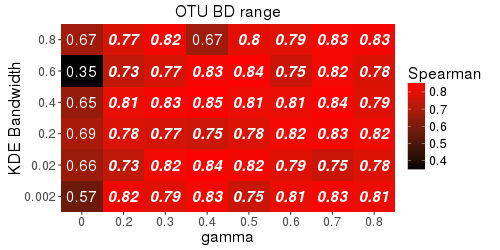

In [76]:
%%R -w 500 -h 250
# getting emperical-emperical corr        
emp.val = df.BDspan.corr %>% 
    filter((dataset.x == 'Emperical' &
            dataset.y == 'Emperical')) %>%
    group_by() %>%
    summarize(max_value = max(spearman, na.rm=TRUE)) %>%
    ungroup() %>%
    select(max_value) %>% as.matrix %>% as.vector
emp.val = emp.val[1]   
        
# filtering 
df.BDspan.corr.f = df.BDspan.corr %>% 
    filter((dataset.x == 'Simulation' &
            dataset.y == 'Emperical')) %>%
    mutate(DBL_scale = DBL_scale %>% as.character,
           bw = bw %>% as.character,
           gt_emp = ifelse(round(spearman,2) >= round(emp.val,2), 'bold.italic', 'plain')) %>%
    complete(DBL_scale, bw)
   
# plotting
p.span = ggplot(df.BDspan.corr.f, aes(DBL_scale, bw, fill=spearman)) +
    geom_tile() +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_discrete(expand=c(0,0)) +
    geom_text(aes(label=spearman_txt, fontface=gt_emp), color='white', size=5.5) +
    scale_color_manual(values=c('white', 'black')) +
    scale_fill_gradient('Spearman', low='black', high='red') +
    labs(x='gamma', y='KDE Bandwidth', title='OTU BD range') +   
    theme(
        text = element_text(size=16),
        plot.title = element_text(size=16)
    )    

p.span

## correlograms (jaccard ~ BD)

In [36]:
sim_corr_files = !find $buildDir -name "OTU_abs1e9_PCR_sub_corr.txt"
print len(sim_corr_files)
print emp_corr_file

192
/home/nick/notebook/SIPSim/dev/fullCyc_trim/SIP-core_unk_trm_corr.txt


In [42]:
# checking for empty files
for x in sim_corr_files:
    ret = !ls -thlc $x
    if ret[0].split(' ')[4] == '0':
        print ret

In [43]:
%%R -i sim_corr_files -i emp_corr_file

df.corr = load.data.files(sim_corr_files, emp_corr_file) 

# binning
df.corr = df.corr %>%
    filter(!is.na(Mantel.corr)) %>%
    group_by(DBL_scale, bw, dataset, library, class.index.bin = ntile(class.index, 12)) 

df.corr %>% tail(n=3) %>% as.data.frame

  library class.index n.dist Mantel.corr    Pr Pr.corr DBL_scale   bw SIM_rep
1       1       0.039     28 -0.10745606 0.003   0.021       0.8 0.02       4
2       1       0.043     26 -0.09722881 0.015   0.072       0.8 0.02       4
3       1       0.047     26 -0.09416614 0.012   0.084       0.8 0.02       4
     dataset class.index.bin
1 Simulation              10
2 Simulation              11
3 Simulation              12


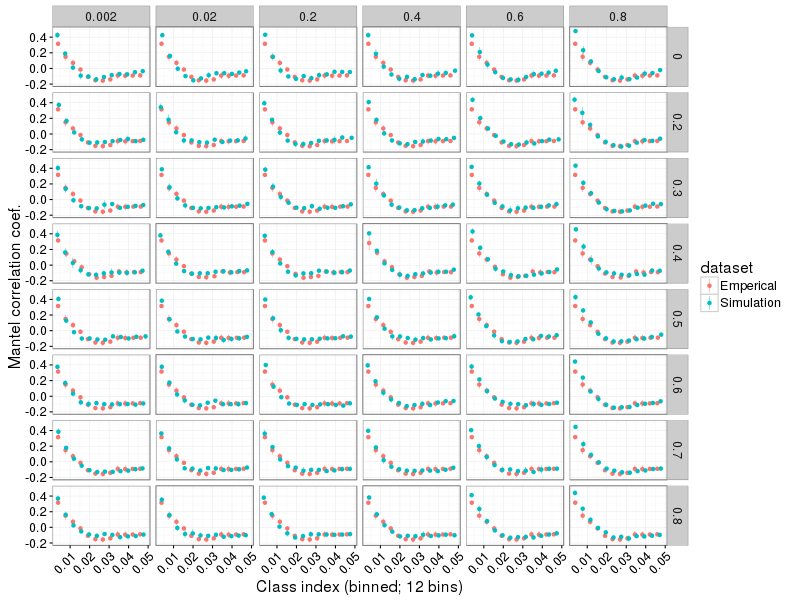

In [44]:
%%R -w 800 -h 600
# plotting
df.corr.s = df.corr %>%
    group_by(DBL_scale, bw, dataset, class.index.bin) %>%
    summarize(mean_Mantel.corr = mean(Mantel.corr),
              sd_Mantel.corr = sd(Mantel.corr), 
              mean_class.index = mean(class.index))

ggplot(df.corr.s, aes(mean_class.index, mean_Mantel.corr, color=dataset,
                     ymin=mean_Mantel.corr-sd_Mantel.corr,
                     ymax=mean_Mantel.corr+sd_Mantel.corr)) +
    geom_pointrange(size=0.2) +
    labs(x='Class index (binned; 12 bins)', y='Mantel correlation coef.') +
    facet_grid(DBL_scale ~ bw) + 
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)        
    )

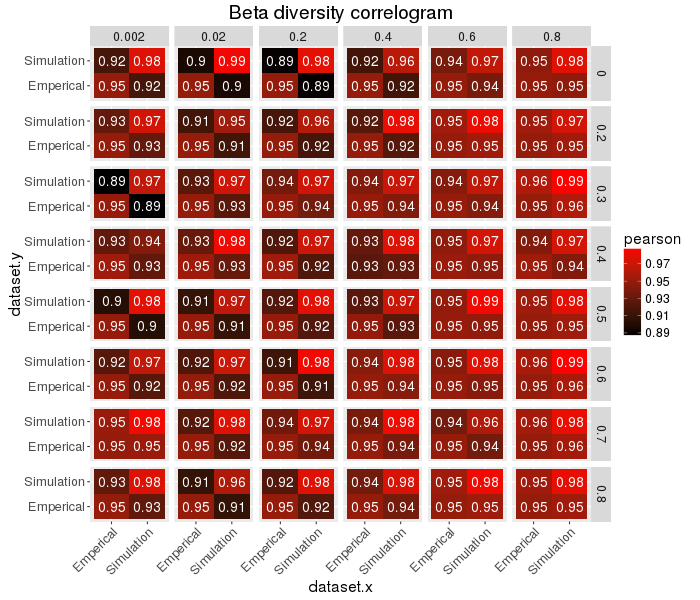

In [45]:
%%R -w 700 -h 600
# pairwise correlations for each dataset
df.shan.bin = df.shan %>%
    group_by(BD_bin = ntile(Buoyant_density, 24))

calc.pearson = function(x){
    cor(x[,'Mantel.corr.x'], x['Mantel.corr.y'], method='pearson')[1,1]
}

df.corr.lm = inner_join(df.corr, df.corr, c('class.index.bin' = 'class.index.bin',
                                                      'bw' = 'bw',
                                                      'DBL_scale' = 'DBL_scale')) %>%
    group_by(bw, DBL_scale, dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))

        
# plotting
ggplot(df.corr.lm, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(title='Beta diversity correlogram') +
    facet_grid(DBL_scale ~ bw) +        
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)            
    )  

[1] 0.953753


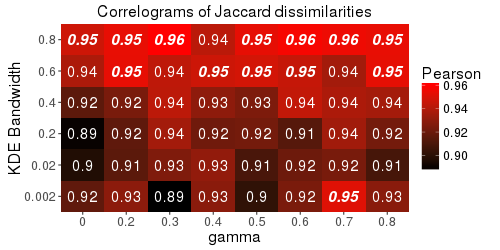

In [71]:
%%R -w 500 -h 250

# getting emperical-emperical corr        
emp.val = df.corr.lm %>% 
    filter((dataset.x == 'Emperical' &
            dataset.y == 'Emperical')) %>%
    group_by() %>%
    summarize(max_value = max(pearson)) %>%
    ungroup() %>%
    select(max_value) %>% as.matrix %>% as.vector
emp.val = emp.val[1]
print(emp.val)    
        
# filtering 
df.corr.lm.f = df.corr.lm %>% 
    filter((dataset.x == 'Simulation' &
            dataset.y == 'Emperical')) %>%
    mutate(DBL_scale = DBL_scale %>% as.character,
           bw = bw %>% as.character,
           gt_emp = ifelse(round(pearson,2) >= round(emp.val,2), 'bold.italic', 'plain')) %>%
    complete(DBL_scale, bw)
df.corr.lm.f %>% head(n=3)
   
        
# plotting
p.corr = ggplot(df.corr.lm.f, aes(DBL_scale,bw, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt,fontface=gt_emp), color='white', size=5.5) +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_discrete(expand=c(0,0)) +
    scale_color_manual(values=c('white', 'black')) +
    scale_fill_gradient('Pearson', low='black', high='red') +
    labs(x='gamma', y='KDE Bandwidth', title='Correlograms of Jaccard dissimilarities') +     
    theme(
        text = element_text(size=16),
        plot.title = element_text(size=16)
    )    
p.corr

# Combined plot

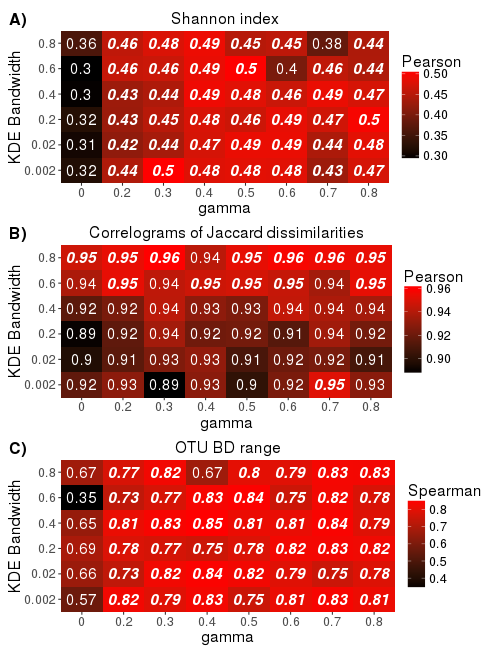

In [85]:
%%R -w 500 -h 650
p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.shan, 0, 0.66, 0.96, 0.33) +
    cowplot::draw_plot(p.corr, 0, 0.33, 0.965, 0.33) +
    cowplot::draw_plot(p.span, 0, 0.00, 1, 0.33) +
    cowplot::draw_plot_label(c('A)', 'B)', 'C)'), c(0,0,0), c(0.99, 0.66, 0.33))
p.comb 

In [87]:
%%R -i workDir
# saving figure
F = file.path(workDir, 'SIM-v-emp_param_optimize.pdf')
ggsave(F, p.comb, width=7.7, height=10)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5//SIM-v-emp_param_optimize.pdf 


# Conclusions

* Optimum bandwidth = 0.8
* Optimum gamma (DBL scaling) = 0.5